In [1]:
import pandas as pd, numpy as np
import pymysql,  os, pickle

from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr

from project_query import live_db_conn, load_data, get_store_location, get_tag, tag_and_type, rec_product_tag
from preprocessing import type_weight, product_tag_set, pearson_sim
from metrics import evaluate_map, evaluate_recall, tag_based_evaluate_map, tag_based_evaluate_recall

pd.set_option('display.max_columns', None)

import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.options.display.float_format = '{:.2f}'.format

#### 1. Data Loading & Preprocessing

1. 데이터 불러오기

In [2]:
total_review = load_data()

print('Order_Review(Raw):',len(total_review))
print('유저 수:',len(total_review['reviewer_name'].unique().tolist()))
print('매장 수:',len(total_review['live_store_id'].unique().tolist()))
print('상품 수:',len(total_review['product_id'].unique().tolist()))

Order_Review(Raw): 52712
유저 수: 11744
매장 수: 398
상품 수: 4400


2. 학습 데이터 정제: tag가 존재하지 않는, 학습에 적절하지 않은 상품들에 대해 학습 데이터에서 제외

In [3]:
product_in_review = total_review['product_id'].unique().tolist()

pir_tag_type = rec_product_tag(product_in_review)

pir_tag_type.dropna(subset='tag_type', inplace=True)

final_product = pir_tag_type['product_id'].tolist()

total_review = total_review[total_review['product_id'].isin(final_product)]

print('[전처리 1: TAG가 존재하지 않는 상품 제외]')
print('리뷰 개수:',len(total_review))
print('유저 수:',len(total_review['reviewer_name'].unique().tolist()))
print('매장 수:',len(total_review['live_store_id'].unique().tolist()))
print('상품 수:',len(total_review['product_id'].unique().tolist()))

total_review.sort_values(by=['order_id','reviewer_name','product_id','updated_at'], ascending=[True,False,False,False], inplace=True)
total_review = total_review.drop_duplicates(subset=['order_id','reviewer_name','product_id'], keep='first')
total_review.loc[total_review['status'] == 'cancel','op_status'] = 'cancel'

order_status_dic = {'cancel':1,'ready':2,'deny':4,'paid':5}

total_review['reviewer_stars'] = total_review['status'].apply(lambda x: order_status_dic[x])

print('[전처리 2: 중복 제거]')
print('리뷰 개수:',len(total_review))
print('유저 수:',len(total_review['reviewer_name'].unique().tolist()))
print('매장 수:',len(total_review['live_store_id'].unique().tolist()))
print('상품 수:',len(total_review['product_id'].unique().tolist()))

[전처리 1: TAG가 존재하지 않는 상품 제외]
리뷰 개수: 31420
유저 수: 6667
매장 수: 273
상품 수: 2779
[전처리 2: 중복 제거]
리뷰 개수: 31042
유저 수: 6667
매장 수: 273
상품 수: 2779


3. 시간 범주형 변수 생성

In [4]:
time_dic = {}

for i in range(0,24):

    if i <= 9:

        time_dic['0{}'.format(str(i))] = i//6

    else:

        time_dic[str(i)] = i//6
        
total_review = total_review[total_review['reserved_at'].notnull()]
total_review['time_label'] = total_review['reserved_at'].apply(lambda x:time_dic[str(x).split(' ')[1].split(':')[0]])

4. 매장 지역 번호

In [5]:
store_location = get_store_location(tuple(total_review['live_store_id'].unique()))

store_location_df = store_location[['store_id','location_master_id']]
total_review = pd.merge(total_review, store_location_df, how = 'inner', left_on = 'live_store_id', right_on = 'store_id')

5. 주문 건수가 8개 이상인 고객 선별

In [6]:
total_review.drop_duplicates(subset=['order_id','reviewer_name','product_id'], inplace=True)

TR_RV_VC = total_review['reviewer_name'].value_counts().reset_index()

# 주문 건수 8개 이상 고객
target_reviewer_name = TR_RV_VC[TR_RV_VC['count'] >= 8]['reviewer_name'].tolist()

# 해당 고객들의 주문 기록
RV_PR = total_review[total_review['reviewer_name'].isin(target_reviewer_name)][['reviewer_name','product_id','reviewer_stars','reserved_at','time_label','location_master_id']]

# 해당 고객들의 주문 상품 리스트
product_id_list = RV_PR['product_id'].unique()

6. 주문된 상품들의 태그 추출

In [7]:
product_tag = get_tag(tuple(product_id_list))

product_tag_dum_df =  pd.get_dummies(product_tag['product_tag_master_id'])
product_tag_dum_df.index = product_tag['product_id']
product_tag_df = product_tag_dum_df.groupby('product_id')[product_tag_dum_df.columns].sum()
product_tag_df.reset_index(inplace=True)

product_tag_df.head()

,product_id,30,60,61,62,66,67,70,71,74,75,76,77,79,81,83,84,87,88,89,90,101,103,104,105,107,109,110,112,115,116,123,129,130,131,132,133,139,140,142,143,144,147,149,150,153,154,155,158,160,162,163,165,166,167,170,171,173,175,180,189,190,191,194,195,197,201,204,206,207,209,211,212,213,214,216,217,218,221,223,224,226,227,228,230,231,233,235,236,237,244,245,246,247,248,249,251,252,253,257,259,266,267,268,270,271,272,273,275,277,278,279,280,284,287,289,295,296,297,298,301,302,303,306,308,310,312,313,321,326,328,331,332,340,341,342,343,344,346,347,350,351,357,358,360,368,369,373,376,380,382,384,385,387,388,389,393,394,395,401,402,403,408,435,445,452,455,457,460,462,464,467,468,472,473,474,479,481,482,483,484,486,487,488,490,492,497,498,501,502,503,504,505,506,507,509,510,511,513,514,515,519,524,528,529,530,531,532,534,536,539,542,549,550,552,553,555,557,561,562,569,572,573,574,578,579,583,586,591,594,595,599,600,601,602,603,604,605,606,607,608,609,613,617,623,624,629,633,635,640,645,650,652,654,656,658,669,677,687,693,699,706,712,717,724,728,732,733,734,737,738,739,744,746,747,748,749,750,751,753,754,758,766,773,774,781,783,785,786,788,795,796,797,801,805,806,810,819,821,822,825,830,836,839,843,846,848,856,866,868,871,872,874,875,878,882,887,888,890,891,896,899,900,901,902,909,919,922,924,927,931,932,933,939,949,959,960,962,964,968,972,975,978,979,986,998,1007,1012,1025,1026,1038,1042,1044,1053,1056,1058,1060,1079,1080,1081,1082,1084,1094,1109,1110,1112,1113,1114,1117,1120,1123,1124,1125,1126,1127,1135,1136,1151,1157,1158,1159,1164,1172,1174,1178,1189,1202,1216,1220,1226,1242,1244,1251,1252,1254,1255,1276,1277,1295,1337,1341,1343,1347,1348,1359,1360,1362,1373,1374,1379,1380,1392,1397,1407,1412,1416,1435,1444,1445,1446,1450,1457,1463,1465,1471,1477,1478,1480,1483,1488,1535,1580,1581,1587,1595,1600,1604,1620,1632,1638,1644,1646,1653,1662,1670,1742,1754,1832,1836,1862,1936,1981,2010,2047,2064,2093,2124,2178,2201,2208,2212
0,20074,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

7. 최종 데이터 프레임 생성

In [8]:
RPST_DF = pd.merge(RV_PR, product_tag_df, how='inner', left_on ='product_id', right_on = 'product_id')

RPST_DF.head()

,reviewer_name,product_id,reviewer_stars,reserved_at,time_label,location_master_id,30,60,61,62,66,67,70,71,74,75,76,77,79,81,83,84,87,88,89,90,101,103,104,105,107,109,110,112,115,116,123,129,130,131,132,133,139,140,142,143,144,147,149,150,153,154,155,158,160,162,163,165,166,167,170,171,173,175,180,189,190,191,194,195,197,201,204,206,207,209,211,212,213,214,216,217,218,221,223,224,226,227,228,230,231,233,235,236,237,244,245,246,247,248,249,251,252,253,257,259,266,267,268,270,271,272,273,275,277,278,279,280,284,287,289,295,296,297,298,301,302,303,306,308,310,312,313,321,326,328,331,332,340,341,342,343,344,346,347,350,351,357,358,360,368,369,373,376,380,382,384,385,387,388,389,393,394,395,401,402,403,408,435,445,452,455,457,460,462,464,467,468,472,473,474,479,481,482,483,484,486,487,488,490,492,497,498,501,502,503,504,505,506,507,509,510,511,513,514,515,519,524,528,529,530,531,532,534,536,539,542,549,550,552,553,555,557,561,562,569,572,573,574,578,579,583,586,591,594,595,599,600,601,602,603,604,605,606,607,608,609,613,617,623,624,629,633,635,640,645,650,652,654,656,658,669,677,687,693,699,706,712,717,724,728,732,733,734,737,738,739,744,746,747,748,749,750,751,753,754,758,766,773,774,781,783,785,786,788,795,796,797,801,805,806,810,819,821,822,825,830,836,839,843,846,848,856,866,868,871,872,874,875,878,882,887,888,890,891,896,899,900,901,902,909,919,922,924,927,931,932,933,939,949,959,960,962,964,968,972,975,978,979,986,998,1007,1012,1025,1026,1038,1042,1044,1053,1056,1058,1060,1079,1080,1081,1082,1084,1094,1109,1110,1112,1113,1114,1117,1120,1123,1124,1125,1126,1127,1135,1136,1151,1157,1158,1159,1164,1172,1174,1178,1189,1202,1216,1220,1226,1242,1244,1251,1252,1254,1255,1276,1277,1295,1337,1341,1343,1347,1348,1359,1360,1362,1373,1374,1379,1380,1392,1397,1407,1412,1416,1435,1444,1445,1446,1450,1457,1463,1465,1471,1477,1478,1480,1483,1488,1535,1580,1581,1587,1595,1600,1604,1620,1632,1638,1644,1646,1653,1662,1670,1742,1754,1832,1836,1862,1936,1981,2010,2047,2064,2093,2124,2178,2201,2208,2212
0,31,24236,2,2021-09-10 12:06:00,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,506,24236,1,2021-11-24 17:00:00,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31,24236,2,2021-11-06 12:30:00,2,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

8. 데이터 분할

In [9]:
train_idx, test_idx= train_test_split(RPST_DF.reviewer_name.unique(), test_size=0.25, random_state=42)

print('유저 수(학습/테스트)', len(train_idx), len(test_idx))

X_TRAIN = RPST_DF[RPST_DF['reviewer_name'].isin(train_idx)]
X_TEST = RPST_DF[RPST_DF['reviewer_name'].isin(test_idx)]

print('데이터 수(학습/테스트)', len(X_TRAIN), len(X_TEST))

TEST_LABEL_DF = X_TEST.sort_values(by=['reviewer_name','reserved_at'], ascending=[False,False]).groupby('reviewer_name').head(5)

TEST_INPUT_DF = X_TEST[~X_TEST.index.isin(TEST_LABEL_DF.index)]

print('테스트 데이터(label/input)',len(TEST_LABEL_DF), len(TEST_INPUT_DF))

유저 수(학습/테스트) 657 219
데이터 수(학습/테스트) 12469 3208
테스트 데이터(label/input) 1095 2113


#### 2. Preprocessing for train

1. 시간 변수 원핫 인코딩

In [10]:
TIME_ENCODER = OneHotEncoder(sparse=False)
TIME_ENCODER.fit(X_TRAIN[['time_label']])

# 인코딩한 데이터로 변환
TIME_ENCODED = TIME_ENCODER.transform(X_TRAIN[['time_label']])

TIME_ENCODED_df = pd.DataFrame(TIME_ENCODED, columns=["time_{}".format(i) for i in range(0,4)])
TIME_ENCODED_df = pd.merge(X_TRAIN[['time_label']].reset_index(), TIME_ENCODED_df, how='inner', left_index=True, right_index=True)

TIME_ENCODED_df.head()

,index,time_label,time_0,time_1,time_2,time_3
0,0,2,0.00,0.00,1.00,0.00
1,1,2,0.00,0.00,1.00,0.00
2,2,2,0.00,0.00,1.00,0.00
3,14,2,0.00,0.00,1.00,0.00
4,15,2,0.00,0.00,1.00,0.00


2. 지역 변수 원핫 인코딩

In [11]:
LOC_ENCODER = OneHotEncoder(sparse=False)
LOC_ENCODER.fit(X_TRAIN[['location_master_id']])

# 인코딩한 데이터로 변환
LOC_ENCODED = LOC_ENCODER.transform(X_TRAIN[['location_master_id']])

LOC_ENCODED_df = pd.DataFrame(LOC_ENCODED, columns=["loc_{}".format(i) for i in range(len(LOC_ENCODED[0]))])

LOC_ENCODED_df = pd.merge(X_TRAIN[['location_master_id']].reset_index(),LOC_ENCODED_df,how='inner', left_index=True, right_index=True)

LOC_ENCODED_df.head()

,index,location_master_id,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,0,2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,14,2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,15,2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


3. 학습 데이터 생성

In [12]:
CONCAT_DF = pd.concat([X_TRAIN[['reviewer_name','reserved_at','product_id','reviewer_stars']].reset_index(), TIME_ENCODED_df, LOC_ENCODED_df], axis= 1).drop(['index','location_master_id','time_label'],axis=1)

CONCAT_DF.head()

,reviewer_name,reserved_at,product_id,reviewer_stars,time_0,time_1,time_2,time_3,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,31,2021-09-10 12:06:00,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,506,2021-11-24 17:00:00,24236,1,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,31,2021-11-06 12:30:00,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,13455,2022-01-29 14:00:00,24236,5,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,7175,2022-02-13 12:00:00,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
TRAIN_CLUSTER_DF = CONCAT_DF.drop('reserved_at',axis=1)

TRAIN_CLUSTER_DF.head()

,reviewer_name,product_id,reviewer_stars,time_0,time_1,time_2,time_3,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,31,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,506,24236,1,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,31,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,13455,24236,5,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,7175,24236,2,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [14]:
# 정규화 작업을 위한 컬럼명 변경
int_columns = TRAIN_CLUSTER_DF.columns[2:].tolist()
string_columns_dict = {i:str(i) for i in int_columns}

TRAIN_CLUSTER_DF.rename(columns=string_columns_dict,inplace=True)

#### 3. Modeling

##### 1. K-Means Clustering => Collaborative Filtering

1. 표준화

In [15]:
# TRAIN

kmeans_scaler = StandardScaler()

TRAIN_CLUSTER_DF[TRAIN_CLUSTER_DF.columns[2:]] = kmeans_scaler.fit_transform(TRAIN_CLUSTER_DF[TRAIN_CLUSTER_DF.columns[2:]])

2. Elbow Method - 군집 수 k 확인

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

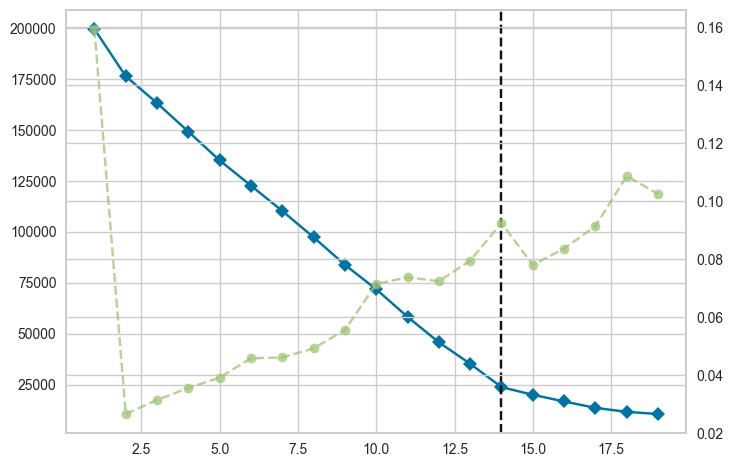

In [16]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(TRAIN_CLUSTER_DF[TRAIN_CLUSTER_DF.columns[2:]])

3. 모델 학습

In [17]:
# TRAIN

kmeans = KMeans(n_clusters=14)
kmeans.fit(TRAIN_CLUSTER_DF[TRAIN_CLUSTER_DF.columns[2:]])

labels = kmeans.labels_
TRAIN_CLUSTER_DF['label'] = labels
TRAIN_CLUSTER_DF['label'].value_counts()

label
0     3439
4     3243
3     1885
1     1119
13     964
2      520
7      354
5      336
8      145
6      145
9      129
12      97
10      82
11      11
Name: count, dtype: int64

#### 4. CB + TEST

In [18]:
test_list = X_TEST['reviewer_name'].unique().tolist()

In [19]:
# 성능 확인을 위한 리스트 
pred_k = 5

result_list = []

for reviewer_name in tqdm(test_list):

    TARGET_TEST_DF = TEST_INPUT_DF[TEST_INPUT_DF['reviewer_name'] == reviewer_name]

    TIME_ENCODED = TIME_ENCODER.transform(TARGET_TEST_DF[['time_label']])

    TIME_ENCODED_df = pd.DataFrame(TIME_ENCODED, columns=["time_{}".format(i) for i in range(0,4)])
    TIME_ENCODED_df = pd.concat([TARGET_TEST_DF[['time_label']].reset_index(), TIME_ENCODED_df], axis=1)
    
    LOC_ENCODED = LOC_ENCODER.transform(TARGET_TEST_DF[['location_master_id']])

    LOC_ENCODED_df = pd.DataFrame(LOC_ENCODED, columns=["loc_{}".format(i) for i in range(11)])
    LOC_ENCODED_df = pd.concat([TARGET_TEST_DF[['location_master_id']].reset_index(), LOC_ENCODED_df], axis=1)

    CONCAT_DF = pd.concat([TARGET_TEST_DF[['reviewer_name','reserved_at','product_id','reviewer_stars']].reset_index(), TIME_ENCODED_df, LOC_ENCODED_df], axis= 1).drop(['index','location_master_id','time_label'],axis=1)
    TEST_CLUSTER_DF = CONCAT_DF.drop('reserved_at', axis=1)
        # 정규화 작업을 위한 컬럼명 변경
    int_columns = TEST_CLUSTER_DF.columns[2:].tolist()
    string_columns_dict = {i:str(i) for i in int_columns}

    TEST_CLUSTER_DF.rename(columns=string_columns_dict,inplace=True)

    TEST_CLUSTER_DF[TEST_CLUSTER_DF.columns[2:]] = kmeans_scaler.transform(TEST_CLUSTER_DF[TEST_CLUSTER_DF.columns[2:]])
    cluster_values = kmeans.predict(TEST_CLUSTER_DF[TEST_CLUSTER_DF.columns[2:]])
    counter = Counter(cluster_values)
    
    # 같은 클러스터 유저들
    SIM_DF = TRAIN_CLUSTER_DF[TRAIN_CLUSTER_DF['label'].isin(cluster_values)]
    idx = 1

    for INPUT_vals in TEST_CLUSTER_DF.values:    
        
        for_sim_IV = INPUT_vals[2:]

        pearosnr_list = []

        for TARGET_vals in SIM_DF.values:
            
            for_sim_TV = TARGET_vals[2:18]
            pearsonr_values = pearsonr(for_sim_IV, for_sim_TV)[0]
            pearosnr_list.append(pearsonr_values)

        SIM_DF['SIMILARITY_{}'.format(idx)] = pearosnr_list
        idx += 1

    SIM_DF['MEAN_SIMILARITY'] = SIM_DF.filter(like='SIMILARITY').mean(axis=1)
    SIM_DF['FINAL_SIMILARITY'] = SIM_DF[['MEAN_SIMILARITY','label']].apply(lambda x: x[0]*counter[x[1]], axis=1)
    SIM_DF.sort_values(by='FINAL_SIMILARITY', ascending=False, inplace=True)
    SIM_DF.drop_duplicates('product_id', keep='first', inplace=True)
    
    target_product_list = SIM_DF['product_id'].unique().tolist()
    target_tag_df = rec_product_tag(target_product_list)

    # 추천 타겟 유저가 구매한 상품들의 TAG
    input_df = TEST_LABEL_DF[TEST_LABEL_DF['reviewer_name'] == reviewer_name]
    input_product_list = input_df['product_id'].unique().tolist()
    input_tag_df = tag_and_type(input_product_list)
    input_tag_df['store_id'] = 0
    input_tag_df['product_id'] = 0

    # 추천 타겟 유저가 구매한 상품이 없거나, 그 상품들의 태그가 없거나, 추천 후보 상품이 없는 예외 케이스
    if len(input_tag_df) == 0 or input_tag_df.iloc[0]['ptm_ids'] == None or len(target_tag_df) == 0: continue

    # 추천 타겟 유저가 구매한 상품들의 TAG TYPE 가중치 반영
    input_ptm = input_tag_df.iloc[0]['ptm_ids'].split(' ')
    input_type = input_tag_df.iloc[0]['tag_type'].split(' ')

    input_type_weight_list = type_weight(input_ptm, input_type)

    input_tag_df.at[0,'ptm_ids'] = ' '.join(input_type_weight_list)

    # 추천 후보 상품의 TAG TYPE 가중치 반영
    for k in range(len(target_tag_df)):
        target_ptm = target_tag_df.iloc[k]['ptm_ids'].split(' ')
        target_type = target_tag_df.iloc[k]['tag_type'].split(' ')

        target_type_weight_list = type_weight(target_ptm, target_type)
        
        target_tag_df.at[k,'ptm_ids'] = ' '.join(target_type_weight_list)

    # 추천 타겟 유저 구매 상품과 추천 후보 상품의 유사도 계산 => 높을 수록 비슷한 상품  
    result = pearson_sim(input_tag_df, target_tag_df)

    product_store_dic = {}
    for vals in target_tag_df.values:
        product_store_dic[vals[1]] = vals[0]

    result = result[result['product_id'] != 0]
    result['store_id'] = result['product_id'].apply(lambda x:product_store_dic[x])

    left = SIM_DF[['product_id','label','FINAL_SIMILARITY']]
    right = result[['product_id','CB 유사도','store_id']]

    result = pd.merge(left, right, how='left', left_on = 'product_id', right_on='product_id')

    min_v = result['FINAL_SIMILARITY'].min()
    max_v = result['FINAL_SIMILARITY'].max()

    result['FINAL_SIMILARITY'] = result['FINAL_SIMILARITY'].apply(lambda x:(x- min_v) / (max_v - min_v))

    min_cv = result['CB 유사도'].min()
    max_cv = result['CB 유사도'].max()

    result['CB 유사도'] = result['CB 유사도'].apply(lambda x:(x- min_cv) / (max_cv - min_cv))
    result['FINAL_SCORE'] = result['FINAL_SIMILARITY'] + result['CB 유사도']
    result.sort_values(by='FINAL_SCORE', ascending=False, inplace=True)
    
    pred = result.head(pred_k)['product_id'].values.tolist()
    label = total_review[total_review['reviewer_name']==reviewer_name]['product_id'].values.tolist()

    result_list.append([reviewer_name,label,pred])

k = 5

final_result = pd.DataFrame(result_list,columns=['user_id','label','pred'])

final_result['PRODUCT_BASED:mAP@{}'.format(k)] = final_result.apply(lambda x: evaluate_map(x['label'],x['pred'],k), axis = 1)
final_result['PRODUCT_BASED:Recall@{}'.format(k)] = final_result.apply(lambda x: evaluate_recall(x['label'],x['pred'],k), axis = 1)

final_result['label_tag_set'] = final_result['label'].apply(lambda x:product_tag_set(x))
final_result['pred_tag_set'] = final_result['pred'].apply(lambda x:product_tag_set(x))

final_result['TAG_BASED:mAP@{}'.format(k)] = final_result.apply(lambda x: tag_based_evaluate_map(x['label_tag_set'],x['pred_tag_set'],k), axis = 1)
final_result['TAG_BASED:Recall@{}'.format(k)] = final_result.apply(lambda x: tag_based_evaluate_recall(x['label_tag_set'],x['pred_tag_set'],k), axis = 1)

product_based_result = [
    [k,final_result['PRODUCT_BASED:mAP@{}'.format(k)].mean(),final_result['PRODUCT_BASED:Recall@{}'.format(k)].mean()]
                 ]
tag_based_result = [
    [k,final_result['TAG_BASED:mAP@{}'.format(k)].mean(),final_result['TAG_BASED:Recall@{}'.format(k)].mean()]
                 ]

print('<Tag_Based>')
Performace_List = tag_based_result[0]

mAP = Performace_List[1]
Recall = Performace_List[2]

print('k: {}'.format(k))
print('mAP@{}: {}'.format(k,mAP))
print('Recall@{}: {}'.format(k,Recall)) 

print('<Product_Based>')
Performace_List = product_based_result[0]

mAP = Performace_List[1]
Recall = Performace_List[2]


print('k: {}'.format(k))
print('mAP@{}: {}'.format(k,mAP))
print('Recall@{}: {}'.format(k,Recall)) 

100%|██████████| 219/219 [1:03:30<00:00, 17.40s/it]


<Tag_Based>
k: 5
mAP@5: 0.556986301369863
Recall@5: 0.6082191780821918
<Product_Based>
k: 5
mAP@5: 0.15158295281582956
Recall@5: 0.22283105022831048
